In [1]:
import sys, os, re, copy
import dill as pickle # this serializes all the functions inside the quantification dict
import numpy as np
import scipy as sp
from scipy.optimize import newton, minimize, fsolve
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
import matplotlib.colors as mcolors
import matplotlib.ticker as tck
from matplotlib.gridspec import GridSpec
palette = list(mcolors.TABLEAU_COLORS.keys())
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': True,
 'axes.spines.top': True
})
sns.set(font_scale=1)
palette = list(mcolors.TABLEAU_COLORS.keys())
sns.set_theme(style="ticks", palette="muted")
sns.set_context("talk")

## Acid hydrolysis based quantification of total amino acids and nucleotides
This notebook works through the quantification of total amino acids and nucleotides in 143B and H1299 cell lines.
Total amino acids and nucleotides should be understood as free amino acids + amino acids bound in proteins/peptides and free nucleotides/nucleosides/nucleobases + nucleotides bound in DNA/RNA.
To generate cell material for acid hydrolysis the following was setup:
* Prior to seeding the experiment, cells had been grown 20 doublings in media with the isotopic labels (U-13C Asn and 15N-amide Gln) used in the experiment. Thus, the fractional labeling was a steady-state at the start of the experiment.
* 3x 6-well plates for each cell line (143B and H1299)
* Seeded at ~100,000 cells/well in DMEM, without pyruvate and glutamine, with 10% dialyzed FBS and 1x penstrep
* 15N-amide Gln was spiked in at 4 mM
* On two plates 100 μM U-13C Asn was spiked in, on one plate 1 mM U-13C Asn was spiked in
* At 50-80% confluency extracted cell material from wells in the top row and counted cells from the wells in the bottom row
* To extract cell material first washed twice with cold saline, the added 1 mL 80% MeOH, scraped cells and transferred material to a clean tube. Then washed each well with 4x 1 mL water to remove any residual cell material.
* The bottom row was counted on a Coulter counter to find the cell count and average cell volume

At this point the cell material was thoroughly mixed and transferred in 1 mL aliquots to 1.5 mL tubes after which the acid hydrolysis protocol began.
Tubes were dried and two replicates were set aside for fast, low temperature acid hydrolysis for nucleobase quantification, two replicates were set aside for slow, high temperature acid hydrolysis for amino acid quantification and one tube was set aside for determining the ratio of labelled vs unlabelled Asn i.e. no acid hydrolysis.
To the acid hydrolysis samples 150 μL 6 M HCl (amino acid analysis quality) was added and nucleobase quantification samples were hydrolyzed at 80C for 2 hours and amino acid quantification samples were hydrolyzed at 90C for 72 hours.
After acid hydrolysis tubes were dried.
Then 1 mL 80% MeOH was added to all tubes, they were thoroughly mixed, spun down and 800 μL was transferred to fresh tubes for the non-hydrolysis samples, 50 μL for nucleobase samples and 20 μL for amino acid samples.
They were all dried and non-hydrolysis samples were reconstituted in 40 μL 80% MeOH whereas acid hydrolysis samples were reconstituted in 40 μL 80% MeOH with U-13C internal standards.
Amino acid quantification samples were also run without U-13C internal standards to determine m+0/m+4 for aspartate as this quantifies the contribution of hydrolyzed asparagine to the measured aspartate concentration.
Finally, the content of each tube was transferred to LCMS vials and quantified.


#### Notes on the use of isotopic labels
The use of U-13C Asn is to label a large fraction of the asparagine that gets incorporated into protein.
Thus, when acid hydrolysis is perform and all the asparagine is deaminated into aspartate the a two can be deconvoluted by using the label.
This does present a slight problem though, as the quantification is also performed by using U-13C internal standards.
I deal with this issue below.

The experiment is also using 15N-amide Gln which was added to account for glycine derived from purine breakdown duirng acid hydrolysis; however, I later found out that I had made a mistake and that the amide nitrogen on glutamine does not label the glycine that gets released from purines.
In fact this glycine from purine breakdown is the same glycine that get incorporatd during purine synthesis, so there is no way of discriminating between the glycine in protein and glycine from purine breakdown.
While to usefull for labelling glycine, the use of 15N-amide Gln does present a slight nuisance in that it introduces a natural abundance error in the nucleobases/nucleosides.
Luckily, the isotopic enrichment of the 15N-amide Gln is almost identical to the natural isotope abundance of 14N, thus cancelling out the natural abundance error.
I still account for the error though, but it only changes the concentrations by a few percent.


#### Limitations to this type of quantification
While LCMS and isotopic internal standards are really good for quantification, there are some important limitations related to undercounting of modified amino acids and nucleosides/nucleobases.
Some abundance amino acid modifiations like phosphorylation, acetylation and glycosylation are cleaved under acid hydrolysis but others like methylation are not.
The same is true for nucleobases were methylation would be expected to cause an underestimate of certain bases.

In [2]:
# Convert amino acid full name to three letter name:
AAcode = {
    'Alanine': 'Ala',
    'Arginine': 'Arg',
    'Asparagine': 'Asn',
    'Aspartate': 'Asp',
    'Glutamate': 'Gln+Glu',
    'Glutamine': 'Gln',
    'Glycine': 'Gly',
    'Isoleucine': 'Ile',
    'Leucine': 'Leu',
    'Lysine': 'Lys',
    'Methionine': 'Met',
    'Phenylalanine': 'Phe',
    'Proline': 'Pro',
    'Serine': 'Ser',
    'Threonine': 'Thr',
    'Tryptophan': 'Trp',
    'Tyrosine': 'Tyr',
    'Valine': 'Val'
}
# Convert nucleobase full name to three letter abreviations:
NB_code = {'Adenine': 'Ade', 'Guanine': 'Gua', 'Uracil': 'Ura', 'Thymine': 'Thy', 'Cytosine': 'Cyt'}

In [3]:
def impute_conc(piece_wise_fit_metab, response_ratio):
    '''
    This function imputes the concentration from a response ratio.
    '''
    response_ratio_range = np.array(list(piece_wise_fit_metab.keys()))
    mask_range = [response_ratio >= min_v and response_ratio <= max_v for max_v, min_v in response_ratio_range]
    k = tuple(response_ratio_range[mask_range][0])
    conc = piece_wise_fit_metab[k](response_ratio)
    estimator = 'intrapolation'
    if 0 in k:
        estimator = 'extrapolation under'
    elif np.inf in k:
        estimator = 'extrapolation over'
    return(conc, estimator)

In [4]:
def NB_ratio_nitrogen(Npos, label_abundance_15N, natural_abundance_14N=0.99636):
    '''
    Calculates a multiplier to correct concentration
    of nitrogen labelled compounds.
    Multiply the return value with the calculated concentration
    to perform the correction.
    Npos = positions that can be labelled
    '''
    # Under natural abundance
    # what is the expected fraction of the compound
    # with _no_ 15N on all the positions that could be labelled:
    frac_natural = sp.stats.binom.pmf(Npos, Npos, natural_abundance_14N)
    # With the label
    # what is the expected fraction of the compound
    # with 15N on all the positions that could be labelled:
    frac_label = sp.stats.binom.pmf(Npos, Npos, label_abundance_15N)
    return(frac_natural/frac_label)

#### Correction for aspartate
Aspartate is a special case for quantification because U-13C labelled asparagine was feed to cell to descriminate protein levels of asparagine and aspartate since protein bound U-13C asparagine turns into U-13C aspartate upon acid hydrolysis; however, the U-13C aspartate is also part of the internal standards for quantification. Thus the U-13C aspartate coming from protein U-13C asparagine has to be decoupled from U-13C aspartate coming from the internal standard. This is achieved by finding the ratio a unlabelled to labelled aspartate, by running samples without internal standards, and then correcting the response ratio accordingly.

Let $A_1$ be the peak area of unlabelled aspartate, $A_2$ be that of U-13C aspartate derived from hydrolyzed U-13C asparagine and $N$ be that derived from the internal standard. We then have:
$$
Y = \frac{A_1}{A_2+N} => N = \frac{A_1}{Y-A_2}
$$

From the ratio we have:
$$
X = \frac{A_1}{A_2} => A_2 = \frac{A_1}{X}
$$

By substitution we get:
$$
N = \frac{A_1}{Y}-\frac{A_1}{X}
$$


And the corrected response ratio ($RR$) for finding the concentration of protein aspartate and asparagine can then be found:
$$
RR = \frac{A_1+A_2}{N} => \frac{A_1+\frac{A_1}{X}}{\frac{A_1}{Y}-\frac{A_1}{X}} => \frac{X+1}{\frac{X}{Y}-1}
$$

The response ratio is converted to a concentration of total aspartate through the calibration curve $f(RR)$. Then the fraction of aspartate from hydrolyzed asparagine is calculated using the aspartate label fraction $X$. Incomplete labelling with asparagine is taken into account by using the fraction of labelled to unlabelled asparagine before acid hydrolysis ($F$). It is not necessary to correct for natural isotope abundance because the 13C enrichment in the U-13C asparagine is approximately equal to the natural 12C abundance. Thus, the final concentration will be:
$$
[Asn] = f(RR) \frac{1}{F(1+X)}
$$

$$
[Asp] = f(RR) (1 - \frac{1}{F(1+X)})
$$




In [5]:
def asp_corr(X, Y, F, f):
    '''
    Calculates the aspartate and asparagine concentration
    based on the above shown correction.
    
    Here is some code I used for testing:
    f_conc = lambda x: x*10
    F = 0.98 # labelling fraction
    A1 = 500+700*(1-F)
    A2 = 700*F
    N = 1000
    X = A1/A2
    Y = A1/(A2+N)
    RR = (X+1)/(X/Y-1)

    Asp_total = f_conc(RR)
    Asn_conc = Asp_total*   1/(F*(X+1))
    Asp_conc = Asp_total*(1-1/(F*(X+1)))

    print(Asp_conc)
    print(Asn_conc)
    assert((Asp_conc+Asn_conc) == Asp_total)
    '''
    RR = (X+1)/(X/Y-1)
    if RR < 0:
        return(0, 0, 'extrapolation under')
    else:
        asp_total, estimator = impute_conc(f, RR)
        asn_conc = asp_total*   1/(F*(X+1))
        asp_conc = asp_total*(1-1/(F*(X+1)))
        return(asp_conc, asn_conc, estimator)

### Perform quantification and export data

In [6]:
# Dict to correct for nitrogen natural isotope abundance:
NB_correct_dict = {
    'Guanine 15N3 pos': 3,
    'Adenine 15N2 pos': 2,
    'Uracil 15N1 neg': 1,
    'Cytosine 15N2 pos': 2,
    'Thymine 15N1 neg': 1,
    'Hypoxanthine 15N2 pos': 2,
    'Xanthine 15N2 neg': 2,
    'Guanosine 15N3 pos': 3,
    'Adenosine 15N2 pos': 2,
    'Uridine 15N1 neg': 1,
    'Cytidine 15N2 pos': 2,
    'Deoxyuridine 15N1 neg': 1,
}
# List of amino acids with quantification data:
AA_quant_list = ['Asparagine', 'Aspartate neg', 'Glutamate neg', 'Arginine pos', 'Tyrosine pos', 'Serine neg', 'Proline pos', 'Threonine neg', 'Lysine pos', 'Leucine pos', 'Valine pos', 'Phenylalanine pos', 'Isoleucine pos', 'Alanine pos']
# All compounds to quantify:
quant_set = set(list(NB_correct_dict.keys()) + AA_quant_list)

In [7]:
### Read quantification function ###
dict_pickle_fnam = 'input/AA-nucleoside_quant-dict.pickle'
with open(dict_pickle_fnam, 'rb') as handle:
    piece_wise_fit_AA_nucs = pickle.load(handle)
dict_pickle_fnam = 'input/nucleobase_quant-dict.pickle'
with open(dict_pickle_fnam, 'rb') as handle:
    piece_wise_fit_nucb = pickle.load(handle)
# Merge the two quantitation dictionaries:
piece_wise_fit_quant = {**piece_wise_fit_AA_nucs, **piece_wise_fit_nucb}

### Read measurements ###
### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('input/143B-H1299_Nuc-Prot_quant.xlsx', sheet_name=None)
annotation_df = pd.read_excel('input/annotations.xlsx')
metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k])
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Area'] / metab_dict_mes[k]['ISTD Response']
        metab_dict_mes[k]['Response Ratio'] = metab_dict_mes[k]['Response Ratio'].fillna(0).replace(np.inf, 0)
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        if 'Aspartate' in k:
            metab_dict_mes[k] = metab_dict_mes[k].drop(['Flag Details', 'Theoretical Amt', 'Filename', 'Type', 'RT', 'Sample ID'], axis=1)
        else:
            metab_dict_mes[k] = metab_dict_mes[k].drop(['Flag Details', 'Theoretical Amt', 'Filename', 'Type', 'RT', 'Sample ID', 'Asp_X', 'Asn_frac'], axis=1)

### Impute concentration and add to metabolite dataframe ###
rr_mes = dict() # for plotting 
imp_conc_mes = dict() # for plotting
for metab in metab_names_mes[:]:
    # Remove 15N from name:
    metab_split = metab.split()
    if len(metab_split) == 4:
        metab_no_iso = ' '.join([metab_split[0], metab_split[1], metab_split[-1]])
    elif len(metab_split) == 3:
        metab_no_iso = ' '.join([metab_split[0], metab_split[-1]])
    elif len(metab_split) == 2:
        metab_no_iso = metab
    else:
        raise Exception('{} not recognized metabolite name format'.format(metab))
    # Assign imputed concentration:
    if metab_no_iso in piece_wise_fit_quant:
        if 'Aspartate' not in metab_no_iso: # special case for aspartate
            conc_list = list()
            estimator_list = list()
            for label_abundance_15N, rr in zip(metab_dict_mes[metab]['Gln_frac'].values, metab_dict_mes[metab]['Response Ratio'].values):
                conc, estimator = impute_conc(piece_wise_fit_quant[metab_no_iso], rr)
                if metab in NB_correct_dict:
                    Npos = NB_correct_dict[metab]
                    NB_mult = NB_ratio_nitrogen(Npos, label_abundance_15N)
                else:
                    NB_mult = 1
                conc_list.append(NB_mult*conc)
                estimator_list.append(estimator)
            metab_dict_mes[metab]['imputed_sample_conc'] = conc_list
            metab_dict_mes[metab]['imputed_sample_estimator'] = estimator_list
        else:
            asp_conc_list = list()
            asn_conc_list = list()
            estimator_list = list()
            for X, Y, F in zip(metab_dict_mes[metab]['Asp_X'].values, metab_dict_mes[metab]['Response Ratio'].values, metab_dict_mes[metab]['Asn_frac'].values):
                asp_conc, asn_conc, estimator = asp_corr(X, Y, F, piece_wise_fit_quant[metab_no_iso])  ###
                asp_conc_list.append(asp_conc)
                asn_conc_list.append(asn_conc)
                estimator_list.append(estimator)
            metab_dict_mes['Asparagine'] = copy.deepcopy(metab_dict_mes[metab])
            metab_names_mes.append('Asparagine')
            metab_dict_mes[metab]['imputed_sample_conc'] = asp_conc_list
            metab_dict_mes[metab]['imputed_sample_estimator'] = estimator_list
            metab_dict_mes['Asparagine']['imputed_sample_conc'] = asn_conc_list
            metab_dict_mes['Asparagine']['imputed_sample_estimator'] = estimator_list

        # Extract data for plotting:
        if metab_no_iso in rr_mes:
            rr_mes[metab_no_iso].extend(list(metab_dict_mes[metab]['Response Ratio'].values))
            imp_conc_mes[metab_no_iso].extend(list(metab_dict_mes[metab]['imputed_sample_conc'].values))
        else:
            rr_mes[metab_no_iso] = list(metab_dict_mes[metab]['Response Ratio'].values)
            imp_conc_mes[metab_no_iso] = list(metab_dict_mes[metab]['imputed_sample_conc'].values)

In [8]:
### Extract all metabolites for quantification ###
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'Formula', 'Response Ratio', 'Area', 'ISTD Response', 'imputed_sample_conc'], axis=1)
for metab in metab_names_mes:
    if metab in quant_set:
        assert(metab_dict_mes[metab]['Sample_name'].equals(df['Sample_name']))
        df[metab] = metab_dict_mes[metab]['imputed_sample_conc']

mask = df['hydrolysis'] != 'none'
df = df[mask]
# Take the mean of the two technical (pipetting) replicates:
df_mean = df.groupby(['cell_line', 'plate', 'replicate', 'hydrolysis']).mean().reset_index()

### Calculate the total cell concentration ###
df_mean_cell_conc = copy.deepcopy(df_mean)
df_mean_cell_conc.loc[:, list(quant_set)] = df_mean_cell_conc.loc[:, list(quant_set)].mul( df_mean_cell_conc['solvent_vol'] / (df_mean_cell_conc['dilution'] * df_mean_cell_conc['frac_transferred'] * df_mean_cell_conc['cell_vol']), axis=0)

def sum_nucl(df_inp):
    ### Sum all the purine/pyrimidine species ###
    guanine_list = ['Guanine 15N3 pos', 'Xanthine 15N2 neg', 'Guanosine 15N3 pos']
    adenine_list = ['Adenine 15N2 pos', 'Hypoxanthine 15N2 pos', 'Adenosine 15N2 pos']
    uracil_list = ['Uracil 15N1 neg', 'Uridine 15N1 neg', 'Deoxyuridine 15N1 neg']
    thymine_list = ['Thymine 15N1 neg']
    cytosine_list = ['Cytosine 15N2 pos', 'Cytidine 15N2 pos']

    df_inp['Guanine'] = df_inp.loc[:, guanine_list].sum(axis=1)
    df_inp = df_inp.drop(guanine_list, axis=1)
    df_inp['Adenine'] = df_inp.loc[:, adenine_list].sum(axis=1)
    df_inp = df_inp.drop(adenine_list, axis=1)
    df_inp['Purines'] = df_inp.loc[:, ['Adenine', 'Guanine']].sum(axis=1)
    df_inp['Uracil'] = df_inp.loc[:, uracil_list].sum(axis=1)
    df_inp = df_inp.drop(uracil_list, axis=1)
    df_inp['Thymine'] = df_inp.loc[:, thymine_list].sum(axis=1)
    df_inp = df_inp.drop(thymine_list, axis=1)
    df_inp['Cytosine'] = df_inp.loc[:, cytosine_list].sum(axis=1)
    df_inp = df_inp.drop(cytosine_list, axis=1)
    df_inp['Pyrimidines'] = df_inp.loc[:, ['Uracil', 'Thymine', 'Cytosine']].sum(axis=1)
    return(df_inp)
df_mean_cell_conc = sum_nucl(copy.deepcopy(df_mean_cell_conc))
# Find the max over rows from the same cell line, plate and well (replicate).
# This is just an easy way of taking concentrations of amino acids from
# long hydrolysis, purines from short hydrolysis etc.
df_mean_cell_conc_max = df_mean_cell_conc.groupby(['cell_line', 'plate', 'replicate']).max().reset_index().drop(['hydrolysis', 'dilution', 'cell_vol', 'solvent_vol', 'frac_transferred', 'Gln_frac', 'cell_numb'], axis=1)
df_mean_cell_conc_max['Purines'] = df_mean_cell_conc_max.loc[:, ['Adenine', 'Guanine']].sum(axis=1)
df_mean_cell_conc_max['Pyrimidines'] = df_mean_cell_conc_max.loc[:, ['Uracil', 'Thymine', 'Cytosine']].sum(axis=1)
# Rename to remove pos/neg:
rename_dict = {nam: nam.split()[0] for nam in df_mean_cell_conc_max.columns.values[3:]}
df_mean_cell_conc_max = df_mean_cell_conc_max.rename(rename_dict, axis=1)
# Write to Excel file:
df_mean_cell_conc_max.to_excel('output/conc.xlsx')

In [9]:
df_mean_cell_conc_max

,cell_line,plate,replicate,Alanine,Arginine,Aspartate,Glutamate,Isoleucine,Leucine,Lysine,...,Tyrosine,Valine,Asparagine,Guanine,Adenine,Purines,Uracil,Thymine,Cytosine,Pyrimidines
0,143B,1,1,36098.231073,23099.650440,33960.428148,91324.789059,15916.622931,37810.172983,34558.063813,...,9013.009872,15868.232167,14209.641058,6284.602353,6635.969121,12920.571474,3595.070867,1478.413140,4473.072622,9546.556629
1,143B,1,2,27355.666287,16261.827977,25489.102193,77495.038071,10167.105908,27536.975856,24565.953482,...,6652.724237,9630.635839,10547.786654,7981.282937,7893.805418,15875.088355,2521.056349,1885.698432,2974.745623,7381.500404
2,143B,1,3,36479.601040,23925.852594,34311.183600,92310.915183,16889.914987,38796.797152,35666.043185,...,9161.662291,16749.258397,14426.544429,7063.877241,7406.787505,14470.664747,3529.984619,1764.475289,4717.959972,10012.419881
3,143B,2,1,44601.628477,26903.889565,41098.613836,104947.756431,15959.345602,43493.393212,40148.577269,...,11245.042137,15853.355158,17082.430854,7621.780744,7995.409014,15617.189757,3585.930220,1802.669408,4969.081615,10357.681244
4,143B,2,2,49600.643022,31884.968717,45968.467151,117953.422335,20643.168943,51868.382575,47567.273882,...,12529.260920,22243.157138,19207.228326,8203.834356,8664.253147,16868.087503,4551.910176,1943.815268,6168.027815,12663.753259
5,143B,2,3,33629.184167,21307.965502,31910.640989,93736.304049,13405.772926,35334.994101,31578.995111,...,9710.615324,13168.852436,13146.119191,7056.191033,7521.155007,14577.346040,3721.954155,1702.426723,4394.458936,9818.839813
6,143B,3,1,37040.066109,25232.951509,28355.780026,86585.440578,17720.601664,39208.899272,36770.694127,...,10779.369470,18691.720826,26992.165606,6708.926122,6950.200686,13659.126808,3403.830369,1728.299846,5519.063602,10651.193817
7,143B,3,2,38349.683425,25944.788596,28128.108482,87129.660312,17860.890946,40273.662007,37617.306087,...,11002.841942,19334.972150,25379.201311,8155.284926,8258.028470,16413.313395,3471.164709,2127.663094,5684.630088,11283.457892
8,143B,3,3,36970.801991,24337.392149,27916.425707,84645.522743,16454.775102,38381.999397,35677.002616,...,10338.038214,18170.137758,25681.511556,6940.442623,7297.566937,14238.009560,3166.640459,1728.832932,5145.991889,10041.465280
9,H1299,1,1,28959.867447,20906.819729,29775.666494,74235.783535,12246.607825,34038.824885,30691.868384,...,8746.970943,12337.589134,13764.837823,4119.494775,3843.119498,7962.614273,2149.057917,960.238456,2689.586079,5798.882451


### Plot quantification data

#### Plot cell composition

In [10]:
# Dataframe for individual compound abundance plotting:
df_plot_abu = copy.deepcopy(df_mean_cell_conc_max)
df_plot_abu = df_plot_abu.rename(columns=AAcode)
df_plot_abu = df_plot_abu.rename(columns=NB_code)
df_plot_abu = df_plot_abu.drop(['Purines', 'Pyrimidines'], axis=1)

# Sort according to most abundance in 143B:
df_plot_abu_mean = df_plot_abu.groupby(['cell_line']).mean().reset_index()
util_cols = df_plot_abu.columns.values[:3]
comp_cols = df_plot_abu.columns.values[3:]
sort_mask = df_plot_abu_mean.loc[0, comp_cols].sort_values(ascending=False).index.values
sort_mask = np.concatenate([util_cols, sort_mask])
df_plot_abu_sort = df_plot_abu.loc[:, sort_mask]
# Convert to mM:
df_plot_abu_sort.loc[:, comp_cols] = df_plot_abu_sort.loc[:, comp_cols]/1000

/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.p

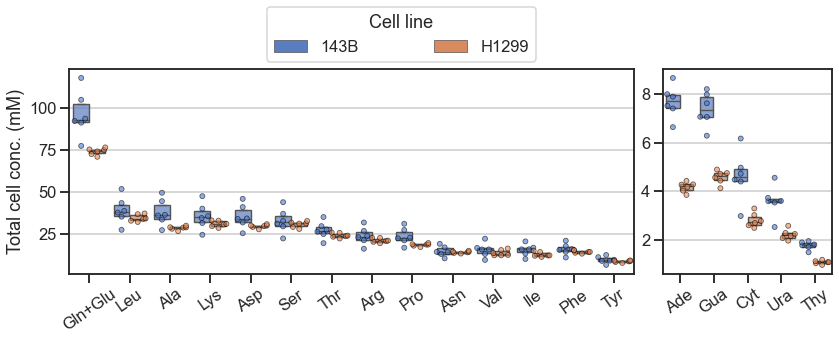

In [11]:
# Skip plate 3, with high concentration Asn supplementation.
# Then flatten for plotting:
mask = df_plot_abu_sort['plate'] != 3
df_abu_flat = pd.melt(df_plot_abu_sort[mask], id_vars=['cell_line', 'plate', 'replicate']).rename(columns={'variable': 'Compound', 'value': 'Concentration'})

# Create plot grid:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(8, 8)
ax1 = fig.add_subplot(gs[1:8,0:6])
#ax2 = fig.add_subplot(gs[1:8,6:8], sharey=ax1)
ax2 = fig.add_subplot(gs[1:8,6:8])
ax3 = fig.add_subplot(gs[0,2:5])

# Plot the amino acids:
inclusion_list = set(AAcode.values())
mask = [v in inclusion_list for v in df_abu_flat['Compound'].values]
g1 = sns.boxplot(ax=ax1, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True)
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)

# Plot individual nucleobases:
inclusion_list = set(NB_code.values())
mask = [v in inclusion_list for v in df_abu_flat['Compound'].values]
g2 = sns.boxplot(ax=ax2, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='Concentration', x='Compound', hue='cell_line', data=df_abu_flat[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True)
g2.grid(True, axis='y')
#g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
#g2.set(yticklabels=[]);

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0,0,1,1), loc="lower left", mode="expand", borderaxespad=0, ncol=2);

# Spacing and print:
fig.tight_layout()
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('output/cell_composition.pdf')

In [12]:
# Read predictions and merged with measurements:
pred_df = pd.read_excel('input/cell_composition_prediction.xlsx')
pred_df = pred_df.rename(columns={'Glutamate + Glutamine': 'Glutamate'})
pred_df = pred_df.rename(columns=AAcode)
pred_df = pred_df.rename(columns=NB_code)
sele_cols = pred_df.columns[1:]
pred_df.loc[:, sele_cols] = pred_df.loc[:, sele_cols]/1000
pred_df_flat = pd.melt(pred_df, id_vars=['cell_line']).rename(columns={'variable': 'Compound', 'value': 'Concentration'})
df_abu_flat_pred = df_abu_flat.merge(pred_df_flat, left_on=['cell_line', 'Compound'], right_on=['cell_line', 'Compound'], suffixes=['_mes', '_pred'])

/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.p

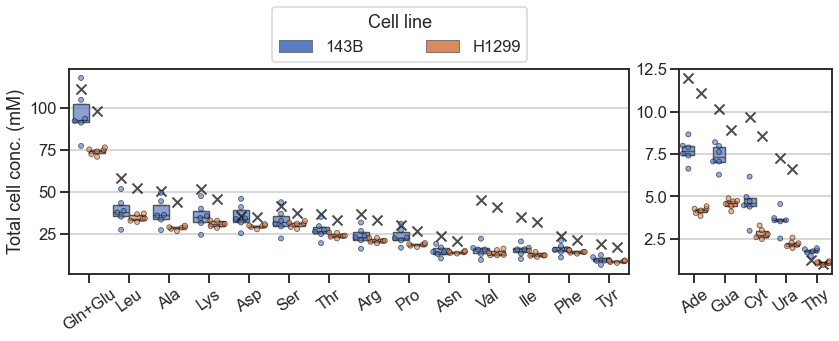

In [13]:
### Add the predictions to above plot ###
# Create plot grid:
fig = plt.figure(figsize=(12, 5))
gs = GridSpec(8, 8)
ax1 = fig.add_subplot(gs[1:8,0:6])
#ax2 = fig.add_subplot(gs[1:8,6:8], sharey=ax1)
ax2 = fig.add_subplot(gs[1:8,6:8])
ax3 = fig.add_subplot(gs[0,2:5])

# Plot the amino acids:
inclusion_list = set(AAcode.values())
mask = [v in inclusion_list for v in df_abu_flat_pred['Compound'].values]
# Add prediction, as a single cross:
one_rep_mask = (df_abu_flat_pred['plate'] == 1) & (df_abu_flat_pred['replicate'] == 1)
g1 = sns.swarmplot(ax=ax1, y='Concentration_pred', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask&one_rep_mask], linewidth=2, alpha=0.7, dodge=True, marker='x', palette=['black', 'black'], s=10)
# Then add the measured data:
g1 = sns.boxplot(ax=ax1, y='Concentration_mes', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='Concentration_mes', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True)
g1.grid(True, axis='y')
#g1.set_yscale('log')
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)

# Plot individual nucleobases:
inclusion_list = set(NB_code.values())
mask = [v in inclusion_list for v in df_abu_flat['Compound'].values]
# Add prediction:
one_rep_mask = (df_abu_flat_pred['plate'] == 1) & (df_abu_flat_pred['replicate'] == 1)
g2 = sns.swarmplot(ax=ax2, y='Concentration_pred', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask&one_rep_mask], linewidth=2, alpha=0.7, dodge=True, marker='x', palette=['black', 'black'], s=10)
# Then measurements:
g2 = sns.boxplot(ax=ax2, y='Concentration_mes', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='Concentration_mes', x='Compound', hue='cell_line', data=df_abu_flat_pred[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True)
g2.grid(True, axis='y')
#g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
#g2.set(yticklabels=[]);

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0,0,1,1), loc="lower left", mode="expand", borderaxespad=0, ncol=2);

# Spacing and print:
fig.tight_layout()
fig.subplots_adjust(hspace=0.3)
fig.savefig('output/cell_composition_w_predictions.pdf')

#### Plot aspartate fates

/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


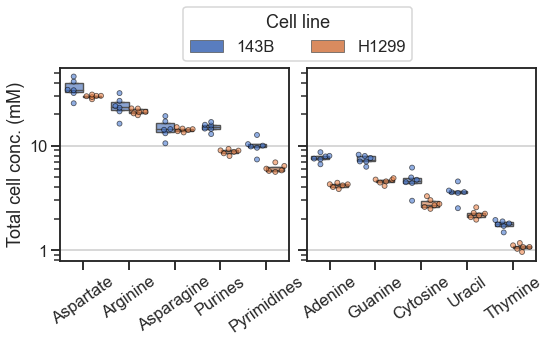

In [14]:
# Extract Asp and its fates: 
df_mean_cell_conc_max_asp = df_mean_cell_conc_max.loc[:, ['cell_line', 'plate', 'replicate', 'Aspartate', 'Arginine', 'Asparagine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']]
# Convert to mM:
df_mean_cell_conc_max_asp.loc[:, ['Aspartate', 'Arginine', 'Asparagine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']] = df_mean_cell_conc_max_asp.loc[:, ['Aspartate', 'Arginine', 'Asparagine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']] / 1000
# Skip plate 3, with high concentration Asn supplementation.
# Then flatten for plotting:
mask = df_mean_cell_conc_max_asp['plate'] != 3
df_flat = pd.melt(df_mean_cell_conc_max_asp[mask], id_vars=['cell_line', 'plate', 'replicate']).rename(columns={'variable': 'Asp fate', 'value': 'Concentration'})

# Create plot grid:
fig = plt.figure(figsize=(8, 5))
gs = GridSpec(8, 8)
ax1 = fig.add_subplot(gs[1:8,0:4])
ax2 = fig.add_subplot(gs[1:8,4:8], sharey=ax1)
ax3 = fig.add_subplot(gs[0,2:6])

# Plot the major Asp fates:
inclusion_list = {'Aspartate', 'Asparagine', 'Arginine', 'Purines', 'Pyrimidines'}
mask = [v in inclusion_list for v in df_flat['Asp fate'].values]
g1 = sns.boxplot(ax=ax1, y='Concentration', x='Asp fate', hue='cell_line', data=df_flat[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='Concentration', x='Asp fate', hue='cell_line', data=df_flat[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True)
g1.grid(True, axis='y')
# g1.set_ylabel('Total cell conc. (μM)');
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)
g1.set_yscale('log')

# Plot individual nucleobases:
inclusion_list = {'Adenine', 'Guanine', 'Uracil', 'Thymine', 'Cytosine'}
mask = [v in inclusion_list for v in df_flat['Asp fate'].values]
g2 = sns.boxplot(ax=ax2, y='Concentration', x='Asp fate', hue='cell_line', data=df_flat[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='Concentration', x='Asp fate', hue='cell_line', data=df_flat[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True)
g2.grid(True, axis='y')
g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
for tk in g2.get_yticklabels():
    tk.set_visible(False)

# Drop scientific notation on numbers:
g1.yaxis.set_major_formatter(tck.FormatStrFormatter('%g'))
g1.yaxis.set_minor_formatter(tck.LogFormatter())

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0,0,1,1), loc="lower left", mode="expand", borderaxespad=0, ncol=2);

# Spacing and print:
fig.tight_layout()
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('output/Asp-fates.pdf')

In [15]:
# Read predictions and merged with measurements:
pred_df = pd.read_excel('input/cell_composition_prediction.xlsx')
pred_df = pred_df.rename(columns={'Glutamate + Glutamine': 'Glutamate'})
sele_cols = pred_df.columns[1:]
pred_df.loc[:, sele_cols] = pred_df.loc[:, sele_cols]/1000
pred_df_flat = pd.melt(pred_df, id_vars=['cell_line']).rename(columns={'variable': 'Asp fate', 'value': 'Concentration'})

# Extract Asp and its fates: 
df_mean_cell_conc_max_asp = df_mean_cell_conc_max.loc[:, ['cell_line', 'plate', 'replicate', 'Aspartate', 'Arginine', 'Asparagine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']]
# Convert to mM:
df_mean_cell_conc_max_asp.loc[:, ['Aspartate', 'Arginine', 'Asparagine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']] = df_mean_cell_conc_max_asp.loc[:, ['Aspartate', 'Arginine', 'Asparagine', 'Adenine', 'Guanine', 'Cytosine', 'Uracil', 'Thymine', 'Purines', 'Pyrimidines']] / 1000
# Skip plate 3, with high concentration Asn supplementation.
# Then flatten for plotting:
mask = df_mean_cell_conc_max_asp['plate'] != 3
df_flat = pd.melt(df_mean_cell_conc_max_asp[mask], id_vars=['cell_line', 'plate', 'replicate']).rename(columns={'variable': 'Asp fate', 'value': 'Concentration'})
# Make the measurement/prediction dataframe:
df_flat_pred = df_flat.merge(pred_df_flat, left_on=['cell_line', 'Asp fate'], right_on=['cell_line', 'Asp fate'], suffixes=['_mes', '_pred'])

/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


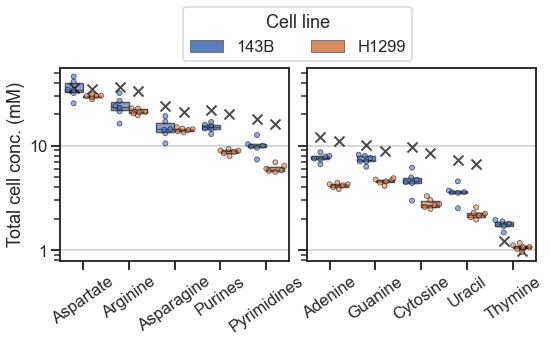

In [16]:
### Add the predictions to above plot ###
# Create plot grid:
fig = plt.figure(figsize=(8, 5))
gs = GridSpec(8, 8)
ax1 = fig.add_subplot(gs[1:8,0:4])
ax2 = fig.add_subplot(gs[1:8,4:8], sharey=ax1)
ax3 = fig.add_subplot(gs[0,2:6])

# Plot the major Asp fates:
inclusion_list = {'Aspartate', 'Asparagine', 'Arginine', 'Purines', 'Pyrimidines'}
mask = [v in inclusion_list for v in df_flat_pred['Asp fate'].values]
# Add prediction, as a single cross:
one_rep_mask = (df_flat_pred['plate'] == 1) & (df_flat_pred['replicate'] == 1)
g1 = sns.swarmplot(ax=ax1, y='Concentration_pred', x='Asp fate', hue='cell_line', data=df_flat_pred[mask&one_rep_mask], linewidth=2, alpha=0.7, dodge=True, marker='x', palette=['black', 'black'], s=10)
# Then add the measured data:
g1 = sns.boxplot(ax=ax1, y='Concentration_mes', x='Asp fate', hue='cell_line', data=df_flat_pred[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g1.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g1 = sns.swarmplot(ax=ax1, y='Concentration_mes', x='Asp fate', hue='cell_line', data=df_flat_pred[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True)
g1.grid(True, axis='y')
# g1.set_ylabel('Total cell conc. (μM)');
g1.set_ylabel('Total cell conc. (mM)');
g1.set_xlabel('');
g1.legend_.remove()
g1.set_xticklabels(g1.get_xticklabels(), rotation=35)
g1.set_yscale('log')

# Plot individual nucleobases:
inclusion_list = {'Adenine', 'Guanine', 'Uracil', 'Thymine', 'Cytosine'}
mask = [v in inclusion_list for v in df_flat_pred['Asp fate'].values]
# Add prediction, as a single cross:
one_rep_mask = (df_flat_pred['plate'] == 1) & (df_flat_pred['replicate'] == 1)
g2 = sns.swarmplot(ax=ax2, y='Concentration_pred', x='Asp fate', hue='cell_line', data=df_flat_pred[mask&one_rep_mask], linewidth=2, alpha=0.7, dodge=True, marker='x', palette=['black', 'black'], s=10)
# Then add the measured data:
g2 = sns.boxplot(ax=ax2, y='Concentration_mes', x='Asp fate', hue='cell_line', data=df_flat_pred[mask], dodge=True, whis=False, fliersize=False, linewidth=1.4)
for patch in g2.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.7))
g2 = sns.swarmplot(ax=ax2, y='Concentration_mes', x='Asp fate', hue='cell_line', data=df_flat_pred[mask], edgecolor='black', linewidth=0.8, alpha=0.6, dodge=True)
g2.grid(True, axis='y')
g2.set_yscale('log')
g2.set_ylabel('');
g2.set_xlabel('');
g2.set_xticklabels(g2.get_xticklabels(), rotation=35);
for tk in g2.get_yticklabels():
    tk.set_visible(False)

# Drop scientific notation on numbers:
g1.yaxis.set_major_formatter(tck.FormatStrFormatter('%g'))
g1.yaxis.set_minor_formatter(tck.LogFormatter())

# Add legend above:
old_legend = g2.legend_
handles = old_legend.legendHandles
labels = ['143B', 'H1299']
title = 'Cell line'
g2.legend_.remove()
ax3.axis('off')
ax3.legend(handles, labels, title=title, bbox_to_anchor=(0,0,1,1), loc="lower left", mode="expand", borderaxespad=0, ncol=2);

# Spacing and print:
fig.tight_layout()
fig.subplots_adjust(wspace=0.4, hspace=0.3)
fig.savefig('output/Asp-fates_w_predictions.pdf')